In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core


!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))



  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!unzip /content/drive/MyDrive/WCEBleedGen.zip

Streaming output truncated to the last 5000 lines.
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1210).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1211).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1212).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1213).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1214).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1215).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1216).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1217).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1218).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1219).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (122).txt  
  inflating: WCEBleedGen/bleeding/Bounding boxes/YOLO_TXT/img- (1220).txt  
  inflating: WCEBleedGen/bleeding/Boun

In [ ]:
import os
import cv2
import numpy as np
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

def get_dataset_dicts(dataset_dir):
    dataset_dicts = []
    images_dir = os.path.join(dataset_dir, "Images")
    annotations_dir = os.path.join(dataset_dir, "Annotations")

    for filename in os.listdir(images_dir):
        if filename.startswith("img-") and filename.endswith(".png"):
            image_id = filename.split(".")[0].split("-")[1]  # Extract image id
            image_path = os.path.join(images_dir, filename)
            annotation_path = os.path.join(annotations_dir, f"ann-{image_id}.png")

            record = {}
            record["file_name"] = image_path
            record["image_id"] = image_id
            record["height"], record["width"] = cv2.imread(image_path).shape[:2]

            # Read annotation mask
            mask = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)

            # Extract individual instances from mask
            objs = []
            for instance_id in np.unique(mask):
                if instance_id == 0:
                    continue  # Skip background
                mask_instance = (mask == instance_id).astype(np.uint8)
                contours, _ = cv2.findContours(mask_instance, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    if contour.size < 6:  # Polygon requires at least 3 points (6 coordinates)
                        continue
                    segmentation = contour.flatten().tolist()
                    bbox = cv2.boundingRect(contour)
                    obj = {
                        "bbox": [bbox[0], bbox[1], bbox[2], bbox[3]],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [segmentation],
                        "category_id": 0,  # Assuming only one category (bleeding region)
                    }
                    objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)

    return dataset_dicts

# Register your dataset
DatasetCatalog.register("dataset5", lambda: get_dataset_dicts("/content/WCEBleedGen/bleeding"))
MetadataCatalog.get("dataset5").set(thing_classes=["bleeding"])

# Optionally, visualize your dataset
dataset_metadata = MetadataCatalog.get("dataset5")


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("dataset5",)
cfg.DATASETS.TEST = ()  # No test set
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (bleeding)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[06/16 16:52:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/16 16:52:44 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/16 16:52:51 d2.utils.events]:  eta: 0:01:38  iter: 19  total_loss: 1.907  loss_cls: 0.6514  loss_box_reg: 0.3975  loss_mask: 0.6909  loss_rpn_cls: 0.07391  loss_rpn_loc: 0.01612    time: 0.3505  last_time: 0.3811  data_time: 0.0239  last_data_time: 0.0116   lr: 1.6068e-05  max_mem: 1937M
[06/16 16:52:58 d2.utils.events]:  eta: 0:01:30  iter: 39  total_loss: 1.642  loss_cls: 0.486  loss_box_reg: 0.4213  loss_mask: 0.6891  loss_rpn_cls: 0.03887  loss_rpn_loc: 0.01081    time: 0.3487  last_time: 0.4135  data_time: 0.0066  last_data_time: 0.0229   lr: 3.2718e-05  max_mem: 1938M
[06/16 16:53:05 d2.utils.events]:  eta: 0:01:24  iter: 59  total_loss: 1.608  loss_cls: 0.3584  loss_box_reg: 0.5224  loss_mask: 0.6835  loss_rpn_cls: 0.06503  loss_rpn_loc: 0.01336    time: 0.3530  last_time: 0.3915  data_time: 0.0149  last_data_time: 0.0121   lr: 4.9367e-05  max_mem: 1938M
[06/16 16:53:12 d2.utils.events]:  eta: 0:01:17  iter: 79  total_loss: 1.4  loss_cls: 0.2915  loss_box_reg: 0.3708  loss_m

/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/16 16:54:14 d2.utils.events]:  eta: 0:00:13  iter: 259  total_loss: 1.222  loss_cls: 0.2274  loss_box_reg: 0.484  loss_mask: 0.4685  loss_rpn_cls: 0.02646  loss_rpn_loc: 0.01224    time: 0.3472  last_time: 0.3130  data_time: 0.0092  last_data_time: 0.0197   lr: 0.00021587  max_mem: 1938M
[06/16 16:54:22 d2.utils.events]:  eta: 0:00:06  iter: 279  total_loss: 1.069  loss_cls: 0.1817  loss_box_reg: 0.4143  loss_mask: 0.4443  loss_rpn_cls: 0.01717  loss_rpn_loc: 0.007309    time: 0.3480  last_time: 0.3429  data_time: 0.0128  last_data_time: 0.0117   lr: 0.00023252  max_mem: 1938M
[06/16 16:54:30 d2.utils.events]:  eta: 0:00:00  iter: 299  total_loss: 1.261  loss_cls: 0.2228  loss_box_reg: 0.4393  loss_mask: 0.4702  loss_rpn_cls: 0.02794  loss_rpn_loc: 0.01252    time: 0.3480  last_time: 0.3612  data_time: 0.0091  last_data_time: 0.0139   lr: 0.00024917  max_mem: 1938M
[06/16 16:54:30 d2.engine.hooks]: Overall training speed: 298 iterations in 0:01:43 (0.3480 s / it)
[06/16 16:54:30 d2

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[06/16 16:54:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
from google.colab.patches import cv2_imshow

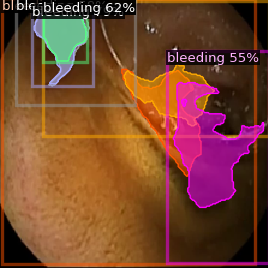

In [ ]:
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
image = cv2.imread("/content/WCEBleedGen/bleeding/Images/img- (1000).png")
mask_path=cv2.imread("/content/WCEBleedGen/bleeding/Images/ann- (1000).png")
# Use the predictor to make predictions
outputs = predictor(image)
pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()

# Visualize predictions
v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
visualized_image = out.get_image()[:, :, ::-1]  # Convert BGR to RGB

from google.colab.patches import cv2_imshow

# Display the visualized image
cv2_imshow(visualized_image)
